In [44]:
import os 
import random
import matplotlib.pylab as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.image import*
import pandas as pd 
import numpy as np 


In [45]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNEL = 3

In [46]:
filenames=os.listdir("dogs-vs-cats/train")
filenames[-5:]


['dog.9995.jpg',
 'dog.9996.jpg',
 'dog.9997.jpg',
 'dog.9998.jpg',
 'dog.9999.jpg']

In [47]:
categories=[]

for fn in filenames:
    category=fn.split(".")[0]
    if category=='dog':
        categories.append(1) # dogs:1
    else:
        categories.append(0) #cats:0

In [48]:
df=pd.DataFrame({'filename':filenames, 'category':categories})
df

#category 컬럼 추가
#dog:1, cat:0


,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0
...,...,...
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1


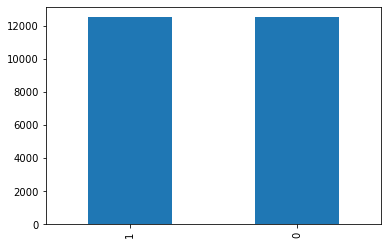

In [49]:
df['category'].value_counts().plot.bar()

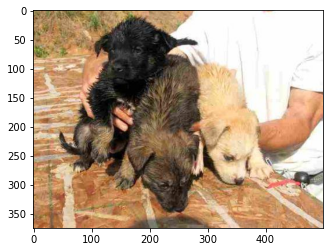

In [50]:
sample=random.choice(filenames) #랜덤하게 이미지 하나를 선택한다
img=load_img("dogs-vs-cats/train/"+sample)
plt.imshow(img)

In [51]:
from keras.models import Sequential
from keras.layers import*

In [52]:
model=Sequential()

model.add(Conv2D(32, (3,3), activation='relu', 
                            input_shape=(IMAGE_WIDTH, 
                                         IMAGE_HEIGHT, 
                                         IMAGE_CHANNEL)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
########################################################
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
########################################################
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
########################################################
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
########################################################
model.add(Dense(2, activation='softmax'))


In [53]:
model.compile(loss="categorical_crossentropy",
                optimizer='rmsprop',
                metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 128)       7

In [54]:
"""
# 조기종료
tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # 관찰대상 (val_acc도 있음)
    min_delta=0,        # 최소변화량 (더 작거나 같으면 중단)
    patience=0,         # 개선이 없어도 결정 유보 (몇번참을지)
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)

# 동적 학습률 조정 ReduceLROnPlateau

tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", # loss 기준해서 학습률 조정
    factor=0.1,         # 개선이 안되면 학습률을 얼마나 줄일지( 곱해서 줄임 )
    patience=10,        # 몇번 참을지
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
    **kwargs
)

"""

'\n# 조기종료\ntf.keras.callbacks.EarlyStopping(\n    monitor="val_loss", # 관찰대상 (val_acc도 있음)\n    min_delta=0,        # 최소변화량 (더 작거나 같으면 중단)\n    patience=0,         # 개선이 없어도 결정 유보 (몇번참을지)\n    verbose=0,\n    mode="auto",\n    baseline=None,\n    restore_best_weights=False,\n)\n\n# 동적 학습률 조정 ReduceLROnPlateau\n\ntf.keras.callbacks.ReduceLROnPlateau(\n    monitor="val_loss", # loss 기준해서 학습률 조정\n    factor=0.1,         # 개선이 안되면 학습률을 얼마나 줄일지( 곱해서 줄임 )\n    patience=10,        # 몇번 참을지\n    verbose=0,\n    mode="auto",\n    min_delta=0.0001,\n    cooldown=0,\n    min_lr=0,\n    **kwargs\n)\n\n'

In [55]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# 조기종료 / 동적 학습률조정
earlystop = EarlyStopping(patience=10)
lrr = ReduceLROnPlateau(monitor="val_acc",
                        patience=2,
                        factor=0.5,
                        min_lr=0.00001)
# callbacks로 묶음
callbacks = [earlystop,lrr]

In [56]:
# 이미지 제너레이터에서는 카테고리에 대해 이름을 주면 구분을 함.
df['category'] = df['category'].replace({0:'cat', 1:'dog'})
df.head()

,filename,category
0,cat.0.jpg,cat
1,cat.1.jpg,cat
2,cat.10.jpg,cat
3,cat.100.jpg,cat
4,cat.1000.jpg,cat


In [57]:
trainDf, valDf = train_test_split(df,
                                    test_size=0.2,
                                    random_state=42)

In [58]:
trainDf['category'].value_counts()

dog    10015
cat     9985
Name: category, dtype: int64

In [59]:
trainDf.head()
trainDf = trainDf.reset_index(drop=True)
valDf = valDf.reset_index(drop=True)

In [60]:
totalTrain = trainDf.shape[0] #2만
totalVal = valDf.shape[0] #5천
batch_size = 15

In [61]:
# 트레이닝 제너레이터
trainDataGen = ImageDataGenerator(
                        rotation_range=15,
                        rescale=1./255,
                        shear_range=0.1,
                        zoom_range=0.2,
                        horizontal_flip=True,
                        width_shift_range=0.1,
                        height_shift_range=0.1
                        )

In [62]:
trainGenerator = trainDataGen.flow_from_dataframe(
                        trainDf,
                        "dogs-vs-cats/train",
                        x_col='filename',
                        y_col='category',
                        target_size=IMAGE_SIZE,
                        class_mode="categorical",
                        batch_size=batch_size
                    )

Found 20000 validated image filenames belonging to 2 classes.


In [63]:
# 검증제너레이터

validationDataGen = ImageDataGenerator(rescale=1./255)
validGenerator = validationDataGen.flow_from_dataframe(
                        valDf,
                        "dogs-vs-cats/train",
                        x_col='filename',
                        y_col='category',
                        target_size=IMAGE_SIZE,
                        class_mode="categorical",
                        batch_size=batch_size
                    )

Found 5000 validated image filenames belonging to 2 classes.


In [64]:
# Generator 작동법 확인/연습
exampleDf = trainDf.sample(1).reset_index(drop=True)
exampleDf
exampleGenerator = trainDataGen.flow_from_dataframe(
                        exampleDf,
                        "dogs-vs-cats/train",
                        x_col='filename',
                        y_col='category',
                        target_size=IMAGE_SIZE,
                        class_mode="categorical",
                        batch_size=batch_size
                    )

Found 1 validated image filenames belonging to 1 classes.


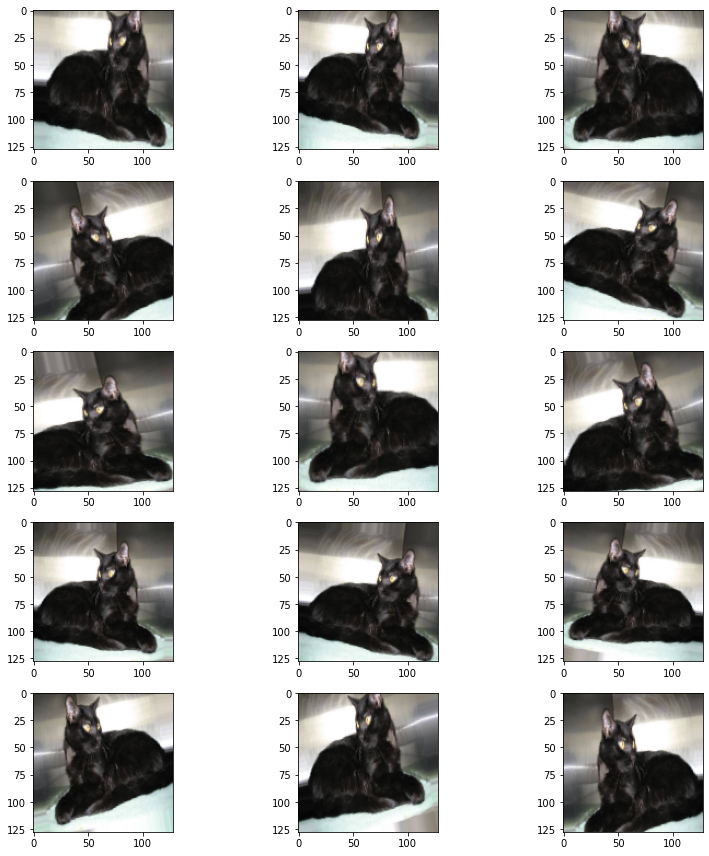

In [65]:
# 이미지 증식 확인

plt.figure(figsize=(12,12))
for i in range(0,15):
    plt.subplot(5,3,i+1)
    for xb, yb in exampleGenerator:
        img = xb[0]
        plt.imshow(img)
        break
plt.tight_layout()
plt.show()

In [66]:
totalTrain = trainDf.shape[0] #2만
totalValid = valDf.shape[0] #5천
batchSize = 15


In [67]:
epochs = 3
history = model.fit_generator(
    trainGenerator,
    epochs=epochs,
    validation_data= validGenerator,
    validation_steps= totalValid//batchSize,
    steps_per_epoch= totalTrain//batchSize,
    callbacks=callbacks
)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
1333/1333 [==============================] - 413s 309ms/step - loss: 0.6743 - accuracy: 0.6222 - val_loss: 0.6348 - val_accuracy: 0.6501 - lr: 0.0010
Epoch 2/3
1333/1333 [==============================] - 400s 300ms/step - loss: 0.5970 - accuracy: 0.6919 - val_loss: 0.4885 - val_accuracy: 0.7670 - lr: 0.0010
Epoch 3/3
1333/1333 [==============================] - 411s 309ms/step - loss: 0.5529 - accuracy: 0.7284 - val_loss: 0.5060 - val_accuracy: 0.7630 - lr: 0.0010


In [ ]:
model.save("model.h5")
model.save_weights("modelw.h5")